In [1]:
import os
import dotenv
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

project_dir = os.path.dirname(os.path.abspath(''))  # might be __file__
print(project_dir)
sys.path.insert(0, project_dir)

from src.utils.utilities import nzvKJ
from src.features.custom_transformers import ColumnExtractor, DFRobustScaler, DFFeatureUnion, DFImputer
from src.features.custom_transformers import DummyTransformer, Log1pTransformer, ZeroFillTransformer
from src.features.custom_transformers import DateFormatter, DateDiffer, MultiEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn import svm
from sklearn.mixture import GaussianMixture as GMM

emotion_codes = {
    'W': 'Ärger (Wut)',
    'L': 'Langeweile',
    'E': 'Ekel',
    'A': 'Angst',
    'F': 'Freude',
    'T': 'Trauer',
    'N': 'Neutral'
}



#project_dir = os.path.join(os.path.dirname(__file__), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

feature_file = os.path.join(project_dir, "data/processed/features.csv")
filename_file = os.path.join(project_dir, "data/processed/filenames.csv")
print(feature_file)
df = pd.read_csv(feature_file, sep=';')
filenames = pd.read_csv(filename_file, sep=';')

y = pd.DataFrame(filenames['filename'].apply(lambda x : x[5]))
y.columns = ['label']

speaker = pd.DataFrame(filenames['filename'].apply(lambda x : x[0:2]))
speaker.columns = ['speaker']

/media/win-d/myfiles/2019/emodb-classifier
/media/win-d/myfiles/2019/emodb-classifier/data/processed/features.csv


In [2]:
print(df.shape)
display(df.head())
wav_path =  os.path.join(project_dir, "data/raw/wav")
wav_files = os.listdir(wav_path)
print('df shape / y shape / N Wav files {}/{}/{}'.format(df.shape[0], y.shape[0], len(wav_files)))

(535, 6375)


,name,frameTime,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,'unknown',0.0,2.935072,0.203297,0.010989,0.295957,0.521095,1.027880,0.225138,0.506785,...,4.534243,0.369439,2.608828,2.575876,79.16969,0.681891,117.0939,56.66211,120.51720,53.83758
1,'unknown',0.0,3.087914,0.155844,0.889610,0.230797,0.747831,1.160158,0.517033,0.412327,...,5.695182,0.373871,3.123539,3.173356,-62.70013,0.684225,126.9756,63.87025,157.94470,60.62523
2,'unknown',0.0,3.673083,0.677778,0.011111,0.379012,0.901301,1.801537,0.522289,0.900236,...,8.072541,0.486622,3.802572,3.807790,-728.79330,0.385978,177.8207,89.42555,153.75670,92.12224
3,'unknown',0.0,3.149658,0.549223,0.720207,0.252871,0.691515,1.456156,0.438644,0.764641,...,8.049535,0.537332,3.237765,3.310604,-44.45128,0.442254,161.9317,82.12952,134.20900,73.30933
4,'unknown',0.0,2.437313,0.632353,0.691177,0.386230,0.809192,1.433426,0.422963,0.624234,...,6.743886,0.511177,2.217382,2.281039,-34.83302,0.492747,106.7201,57.31511,97.52015,41.16851


df shape / y shape / N Wav files 535/535/535


## Basic Feature Selection

Only Kuhn Johnson nonzero variabce implemented


TODO: Improve
http://scikit-learn.org/stable/modules/feature_selection.html



In [3]:
dropvars = ['filename', 'name', 'frameTime']
nearZeroVar =  nzvKJ(df, df.columns)
# nearZeroVar =  nzvKJ(X_train,X_train.columns,freqCut = 20.)
varlist2drop = nearZeroVar[nearZeroVar['nzv']].index.tolist()

In [4]:
vars2remove = list(set(varlist2drop + dropvars))
vars2remove

['filename',
 'pcm_fftMag_spectralRollOff25.0_sma_percentile1.0',
 'logHNR_sma_percentile1.0',
 'logHNR_sma_minPos',
 'name',
 'frameTime']

In [5]:
NUM_FEATS = list(df.select_dtypes(include=['float64', 'int64']).columns)
NUM_FEATS = [x for x in NUM_FEATS if x not in vars2remove]
CAT_FEATS = list(df.select_dtypes(include=['object']).columns)
CAT_FEATS = [x for x in CAT_FEATS if x not in vars2remove]
CAT_FEATS



[]

## Explore Target Variable



In [6]:
y['label'].value_counts()

W    127
L     81
N     79
F     71
A     69
T     62
E     46
Name: label, dtype: int64

## Data Split / Pipeline / Target Transform / Resampling

### Split dataset into Train Test by - Speaker Assignment

In [7]:
random_state = 42
train_size = 2./3
speaker_values = list(np.unique(speaker.values))
n_speakers = len(speaker_values)
train, test = train_test_split(speaker_values, random_state=random_state, train_size=train_size)
print('There should be approx 2/3 of the speakers in train: {}'.format(len(train) / n_speakers))
train, test
train_filter = speaker['speaker'].apply(lambda x: x in train) 
test_filter = speaker['speaker'].apply(lambda x: x in test) 
print(speaker.shape[0])
pd.crosstab(train_filter, test_filter)

There should be approx 2/3 of the speakers in train: 0.6
535


speaker,False,True
speaker,,
False,337,0
True,0,198


In [8]:
df_train = df[train_filter]
df_test = df[test_filter]
y_train = y[train_filter]
y_test = y[test_filter]
print(df_train.shape, df_test.shape, y_train.shape, y_test.shape)

(337, 6375) (198, 6375) (337, 1) (198, 1)


### Feature Pipeline and Target Transform 

In [9]:
# Preprocessing with a Pipeline that uses Pandas Capable Processors
pipeline = Pipeline([
    ('features', DFFeatureUnion([
        ('categoricals', Pipeline([
            ('extract', ColumnExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer())
        ])),
        ('numerics', Pipeline([
            ('extract', ColumnExtractor(NUM_FEATS)),
            ('zero_fill', ZeroFillTransformer())
        ]))
    ])),
    ('std_scaler', preprocessing.StandardScaler())
])
pipeline.fit(df_train)

# ('scale', DFRobustScaler())
# ('std_scaler', preprocessing.StandardScaler()),
# ('reduce_dim', MaskedPCA(n_components=337, mask=None)),
#  ('scale', DFRobustScaler()),
#  ('mpca', MaskedPCA(n_components=337, mask=None))

Pipeline(memory=None,
         steps=[('features',
                 <src.features.custom_transformers.DFFeatureUnion object at 0x7f337e4b9278>),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [10]:
X_train_t = pipeline.transform(df_train)
X_test_t = pipeline.transform(df_test)

In [11]:
print(X_train_t.shape)
print(df_train.shape)
print(X_test_t.shape)
print(df_test.shape)

#df_test.shape

(337, 6370)
(337, 6375)
(198, 6370)
(198, 6375)


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

class MaskedPCA(TransformerMixin):
    """
    https://stackoverflow.com/questions/24124622/pipeline-with-pca-on-feature-subset-only-in-scikit-learn
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    """
    def __init__(self, n_components=2, mask=None):  
        # mask should contain selected cols. Suppose it is boolean to avoid code overhead
        self.n_components = n_components
        self.mask = mask

    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.n_components)
        mask = self.mask
        # mask = self.mask if self.mask is not None else slice(None)
        #self.pca.fit(X[:, mask])
        self.pca.fit(X)
        return self

    def transform(self, X):
        # mask = self.mask if self.mask is not None else slice(None)
        pca_transformed = pd.DataFrame(self.pca.transform(X))
        #if self.mask is not None:
        #    remaining_cols = X[:, ~mask]
        #    return np.hstack([remaining_cols, pca_transformed])
        #else:
        return pca_transformed

    def inverse_transform(self, X):
        if self.mask is not None:
            # Inverse transform appropriate data
            inv_mask = np.arange(len(X[0])) >= sum(~self.mask)
            inv_transformed = self.pca.inverse_transform(X[:, inv_mask])

            # Place inverse transformed columns back in their original order
            inv_transformed_reorder = np.zeros([len(X), len(self.mask)])
            inv_transformed_reorder[:, self.mask] = inv_transformed
            inv_transformed_reorder[:, ~self.mask] = X[:, ~inv_mask]
            return inv_transformed_reorder
        else:
            return self.pca.inverse_transform(X)

In [13]:
# explore PCA Transform 
#mpca = MaskedPCA(n_components=100, mask=None)
#mpca.fit(X_train_t)
#X_train_t_t = mpca.transform(X_train_t)
#X_train_t_t.shape
#mpca.pca.explained_variance_

In [14]:
lb = preprocessing.LabelBinarizer()
label_encoder = LabelEncoder()
y_train_t = label_encoder.fit_transform(y_train.values)
y_test_enc = label_encoder.fit_transform(y_test)
print(pd.Series(y_train_t).value_counts())
label_encoder.classes_

6    76
3    52
2    45
0    45
4    43
5    38
1    38
dtype: int64


/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['A', 'E', 'F', 'L', 'N', 'T', 'W'], dtype=object)

### Resampling Training Data

In [15]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
#X, y = make_classification(n_classes=2, class_sep=2,
#... weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
#... n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
#>>> print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_train_t_res, y_train_t_res = sm.fit_resample(X_train_t, y_train_t)
print('Resampled dataset shape %s' % Counter(y_train_t_res))
# Resampled dataset shape Counter({0: 900, 1: 900})
print("resampled shape", X_train_t_res.shape)
print("original shape", X_train_t.shape)
# 637 / 91 gives number of emotions

Using TensorFlow backend.
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/christian/.venvs/py36/lib/python3.6

Resampled dataset shape Counter({1: 76, 2: 76, 4: 76, 6: 76, 3: 76, 5: 76, 0: 76})
resampled shape (532, 6370)
original shape (337, 6370)


/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/christian/.venvs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/christian/.venvs/py36/lib/python3.6/site

# Fit Models

https://elitedatascience.com/imbalanced-classes

## GMM

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusionmatrix(clf, y_test, y_pred, labels, cmap=plt.cm.Blues, title=''):
    """Utility to plot confusion matrix from Classifier
    clf - sklearn trained classifier
    y_test - test data. They are preprocessed, e.g. run through a label encoder
    y_pred - they come from the model
    labels - label names(len N Classes)
    cmap - color map)
    """

    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels, rotation=90)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



In [19]:
GMM?

In [17]:
n_classes = len(np.unique(y_train))
# covariance_type=covar_type ['spherical', 'diag', 'tied', 'full']
# 
# Try GMMs using different types of covariances.
#classifiers = dict((covar_type, GMM(n_components=n_classes,
#                    covariance_type=covar_type, init_params='wc', n_iter=20))
#                   for covar_type in ['spherical', 'diag', 'tied', 'full'])


gmm_clf = GMM(n_components=n_classes, covariance_type='spherical', n_init=5, means_init=pd.DataFrame(X_train_t_res).groupby(y_train_t_res).mean().values)
# gmm_clf = GMM(n_components=500, covariance_type='spherical', n_init=50)
# gmm_clf.fit(X_train_t_res, y_train_t_res) 
gmm_clf.fit(X_train_t_res) 
# means_init

# gmm_clf?
# https://stackoverflow.com/questions/58714783/unstable-accuracy-of-gaussian-mixture-model-classifier-from-sklearn
# GMM?
# https://stackoverflow.com/questions/58714783/unstable-accuracy-of-gaussian-mixture-model-classifier-from-sklearn
# https://www.researchgate.net/post/How_can_I_use_a_Gaussian_mixture_model_for_the_classification

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=array([[-0.07628591,  0.56375514, -0.07264341, ...,  0.0106416 ,
         0.1603241 ,  0.0840262 ],
       [-0.014052  ,  0.08382793,  0.13732467, ..., -0.23945737,
        -0.39394525, -0.32432904],
       [ 0.46266846,  0.21342106,  0.20584254, ...,  0.87138955,
         0.84011277,  0.71064128],
       ...,
       [-0.62537726, -0.66801703,  0.14577049, ..., -0.48337466,
        -0.53408477, -0.52241845],
       [-1.21366535, -0.26013869,  0.20519453, ..., -0.71845524,
        -0.95210914, -0.68158436],
       [ 0.87366516,  0.43826998, -0.19061871, ...,  0.67727339,
         0.8536321 ,  0.61373645]]),
                n_components=7, n_init=5, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [18]:
# Standard Scaler, full
y_pred = gmm_clf.predict(X_test_t) 
#classification_report(y_test_enc, y_pred, output_dict=True)
print(classification_report(y_test_enc, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.42      0.62      0.50        24
           1       0.00      0.00      0.00         8
           2       0.23      0.35      0.28        26
           3       0.58      0.48      0.53        29
           4       0.33      0.28      0.30        36
           5       0.95      0.83      0.89        24
           6       0.51      0.47      0.49        51

    accuracy                           0.46       198
   macro avg       0.43      0.43      0.43       198
weighted avg       0.47      0.46      0.46       198



In [230]:
# Standard Scaler, sperical
y_pred = gmm_clf.predict(X_test_t) 
#classification_report(y_test_enc, y_pred, output_dict=True)
print(classification_report(y_test_enc, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47        24
           1       0.67      0.25      0.36         8
           2       0.24      0.42      0.31        26
           3       0.75      0.62      0.68        29
           4       0.59      0.53      0.56        36
           5       0.95      0.83      0.89        24
           6       0.62      0.55      0.58        51

    accuracy                           0.56       198
   macro avg       0.61      0.53      0.55       198
weighted avg       0.61      0.56      0.57       198



In [193]:

# Robust Scaler
y_pred = gmm_clf.predict(X_test_t) 
#classification_report(y_test_enc, y_pred, output_dict=True)
print(classification_report(y_test_enc, y_pred, output_dict=False))

              precision    recall  f1-score   support

           0       0.15      0.79      0.25        24
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        29
           4       0.22      0.14      0.17        36
           5       0.00      0.00      0.00        24
           6       0.21      0.20      0.20        51

    accuracy                           0.17       198
   macro avg       0.08      0.16      0.09       198
weighted avg       0.11      0.17      0.11       198



/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVM

In [207]:
svm_clf = svm.LinearSVC()
svm_clf.fit(X_train_t_res, y_train_t_res) 
# Alternative:  class_weight='balanced',

/home/christian/.venvs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [209]:
# Standard Scaler
X_test_t = pipeline.transform(df_test)
y_pred = svm_clf.predict(X_test_t) 


print(classification_report(y_test_enc, y_pred))
# classification_report(y_test_enc, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84        24
           1       0.46      0.75      0.57         8
           2       0.69      0.69      0.69        26
           3       0.90      0.90      0.90        29
           4       0.83      0.81      0.82        36
           5       0.88      0.96      0.92        24
           6       0.90      0.84      0.87        51

    accuracy                           0.83       198
   macro avg       0.79      0.82      0.80       198
weighted avg       0.84      0.83      0.83       198



In [195]:
# RObust Scaler
X_test_t = pipeline.transform(df_test)
y_pred = svm_clf.predict(X_test_t) 


print(classification_report(y_test_enc, y_pred))
classification_report(y_test_enc, y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.45      0.38      0.41        24
           1       0.31      0.62      0.42         8
           2       0.31      0.38      0.34        26
           3       0.58      0.66      0.61        29
           4       0.59      0.36      0.45        36
           5       0.88      0.58      0.70        24
           6       0.75      0.86      0.80        51

    accuracy                           0.58       198
   macro avg       0.55      0.55      0.53       198
weighted avg       0.60      0.58      0.57       198



{'0': {'precision': 0.45,
  'recall': 0.375,
  'f1-score': 0.4090909090909091,
  'support': 24},
 '1': {'precision': 0.3125,
  'recall': 0.625,
  'f1-score': 0.4166666666666667,
  'support': 8},
 '2': {'precision': 0.3125,
  'recall': 0.38461538461538464,
  'f1-score': 0.3448275862068966,
  'support': 26},
 '3': {'precision': 0.5757575757575758,
  'recall': 0.6551724137931034,
  'f1-score': 0.6129032258064515,
  'support': 29},
 '4': {'precision': 0.5909090909090909,
  'recall': 0.3611111111111111,
  'f1-score': 0.4482758620689656,
  'support': 36},
 '5': {'precision': 0.875,
  'recall': 0.5833333333333334,
  'f1-score': 0.7000000000000001,
  'support': 24},
 '6': {'precision': 0.7457627118644068,
  'recall': 0.8627450980392157,
  'f1-score': 0.8,
  'support': 51},
 'accuracy': 0.5757575757575758,
 'macro avg': {'precision': 0.5517756255044391,
  'recall': 0.5495681915560212,
  'f1-score': 0.5331091785485558,
  'support': 198},
 'weighted avg': {'precision': 0.5981242185595037,
  'reca

## Generate Report

In [196]:
np.set_printoptions(precision=2)

In [143]:
display(confusion_matrix(y_test_enc, y_pred))
label_encoder.classes_

array([[ 8,  6,  4,  0,  3,  0,  3],
       [ 1,  6,  0,  0,  0,  0,  1],
       [ 2,  6,  9,  1,  2,  0,  6],
       [ 0,  4,  5, 17,  3,  0,  0],
       [ 4, 11,  9,  1,  9,  0,  2],
       [ 0,  6,  3,  3,  0, 11,  1],
       [ 1,  3,  2,  0,  0,  0, 45]])

array(['A', 'E', 'F', 'L', 'N', 'T', 'W'], dtype=object)

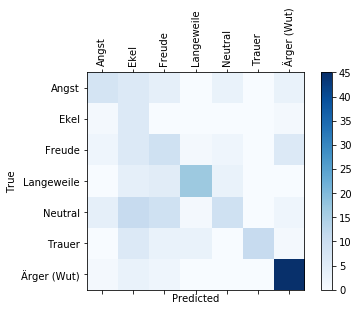

In [144]:
labels = [emotion_codes[x] for x in label_encoder.classes_]
plot_confusionmatrix(svm_clf, y_test_enc, y_pred, labels, cmap=plt.cm.Blues)

In [145]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1)),
                       ("svd", TruncatedSVD(n_components=2))])
X = [[0., 1., 3], [2., 2., 5]]
union.fit_transform(X)
#array([[ 1.5       ,  3.0...,  0.8...],
#       [-1.5       ,  5.7..., -0.4...]])

array([[ 1.5 ,  3.04,  0.87],
       [-1.5 ,  5.73, -0.46]])